# Dog Breed Classification Model 🐶

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

A file with prediction probabilities of each dog breed for each test image.

## 4. Features

Info about the data:
* Using unstructured data (images) so will be best to use deep learning/transfer learning.
* There are 120 breeds meaning, 120 different classes.
* There are 10,000+ images in the training set (with labels)
* There are 10,000+ images in the test set (no labels) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


In [2]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")


GPU available


## Getting our data ready (turning it into Tensors)

In [3]:
# Checkout the labels of our data
labels_csv = pd.read_csv("data/labels.csv")
labels_csv.describe()


,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [4]:
labels_csv.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<AxesSubplot:>

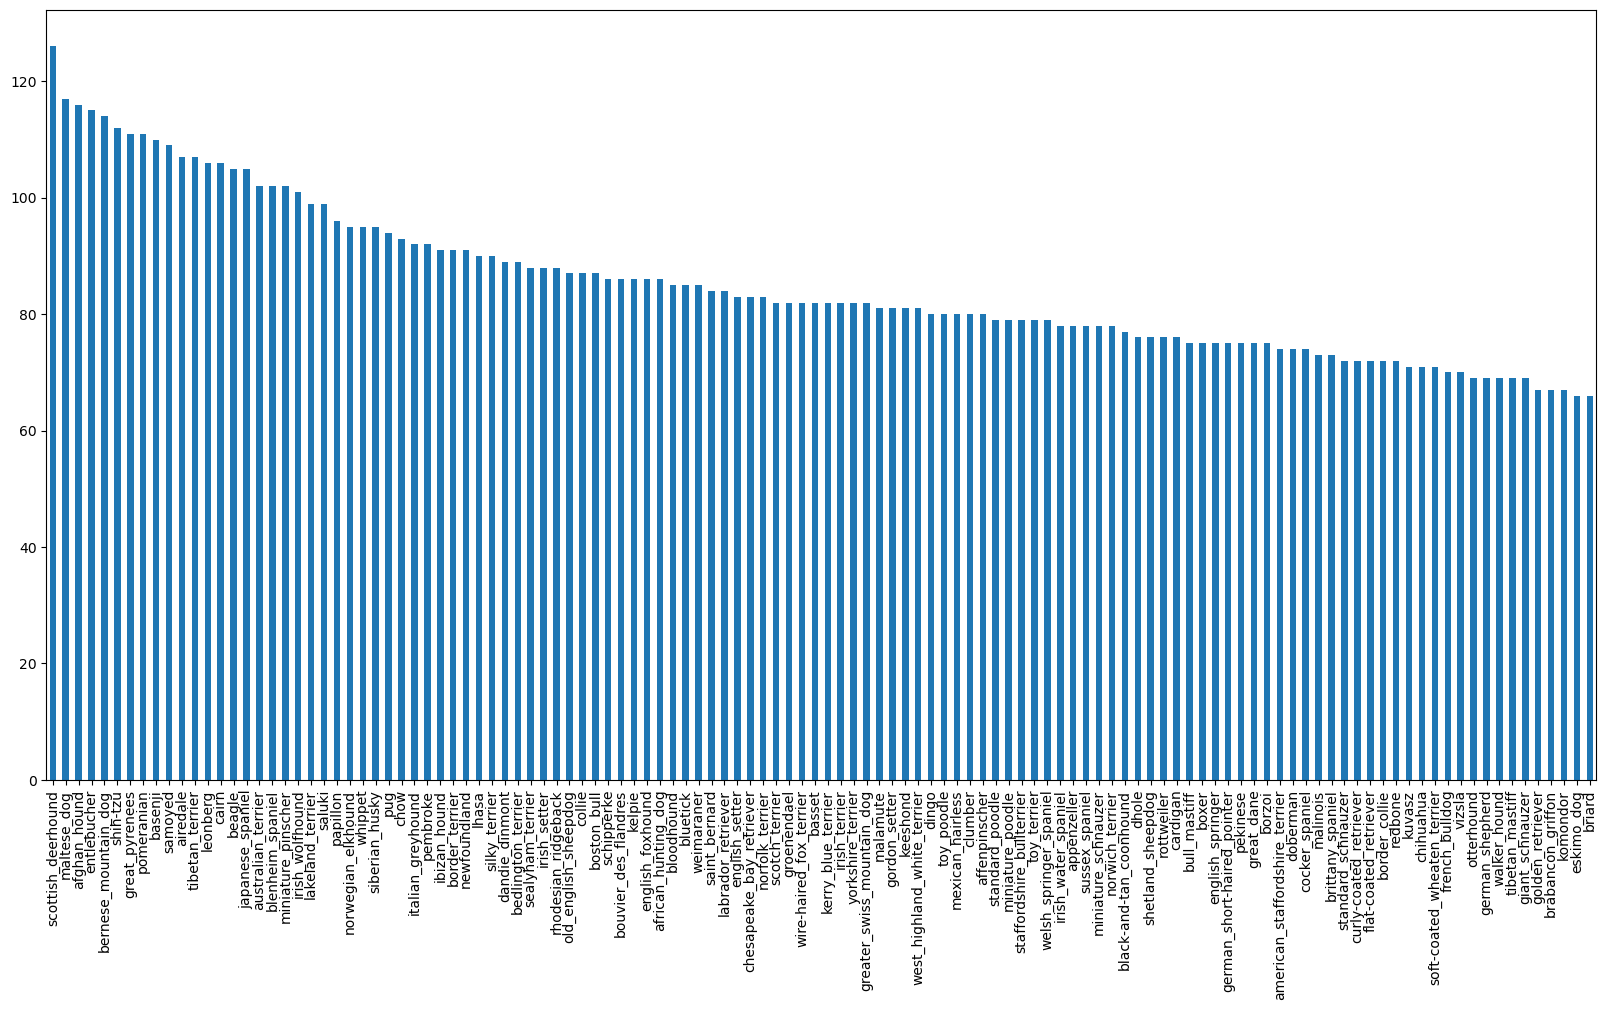

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))


In [6]:
labels_csv["breed"].value_counts().median()


82.0

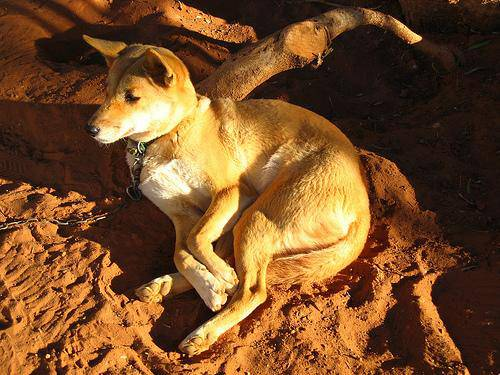

In [7]:
# View an image
from IPython.display import Image

Image("data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")


### Getting images and their labels

In [8]:
# Create a list of all image ID's
filenames = []
for fname in labels_csv["id"]:
    filenames.append(f"data/train/{fname}.jpg")

filenames[:10]


['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check if number of filenames matches number of actual train images files
import os

if len(os.listdir("data/train/")) == len(filenames):
    print("Yes")
else:
    print("No")


Yes


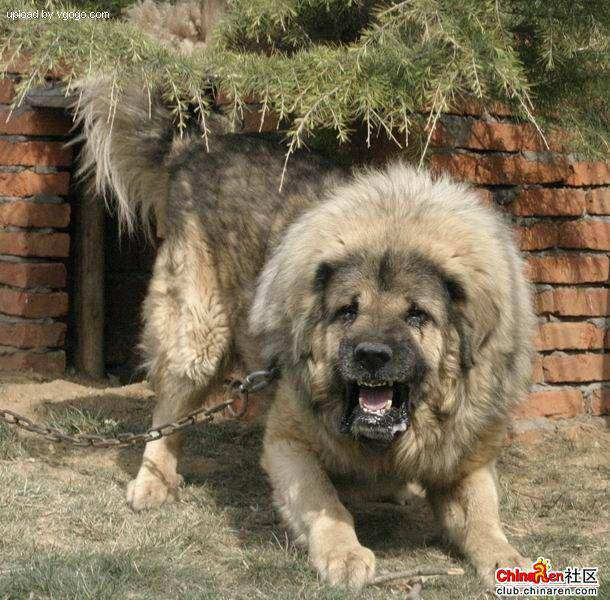

In [10]:
Image(filenames[9000])


In [11]:
labels_csv["breed"][9000]


'tibetan_mastiff'

In [12]:
# Create labels
labels = np.array(labels_csv["breed"])
labels[:10], len(labels)


(array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
        'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
        'scottish_deerhound'], dtype=object),
 10222)

In [13]:
len(labels_csv) == len(filenames)


True

In [14]:
# Find the unique values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)


(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds


boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)


10222

In [18]:
# Example: Turning boolean array into integers
print(labels[0])  # Original label
print(np.where(unique_breeds == labels[0]))  # Index where label occurs
print(boolean_labels[0].argmax())  # Index where label occurs in boolean array
print(boolean_labels[0].astype(int))  # There will be a 1 where the sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Create validation set

In [19]:
# Create X and y varibales
X = filenames
y = boolean_labels


In [20]:
# Set number of images to use for experiment (1000)
NUM_IMAGES = 1000


In [21]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42
)
len(X_train), len(X_val), len(y_train), len(y_val)


(800, 200, 800, 200)

### Preprocessing Images (turning images into Tensors)

Write a function that:
1. Takes an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn `image` (a jpg) into Tensors
4. Normalize image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be size (224x224)
6. Return the modified image

In [22]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 color channels (RBG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (224, 244)
    image = tf.image.resize(image, size=(IMG_SIZE, IMG_SIZE))
    return image


### Turning our data into batches 

All images might not fit into RAM at one time, so we do 32 (batch size) at a time.

In order to use TensorFlow effectivly, data needs to be in the form of a Tensor tuple (image, label).

In [23]:
# Create function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the assosciated label, processes the image and returns a tuple (image, label)
    """
    image = process_image(image_path)
    return image, label


In [24]:
process_image(X[42]), tf.constant(y[42])


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-02 07:36:14.536854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 07:36:14.537281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.2389375 ],
         ...,
         [0.29325107, 0.5189916 , 0.32155466],
         [0.29721776, 0.52466875, 0.33030325],
         [0.2948505 , 0.5223015 , 0.3340662 ]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692955, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247737],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634811, 0.03442093

In [25]:
BATCH_SIZE = 32

# Fucntion to turn data into batch
def create_data_batches(
    X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False
):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accpets test data as input (no labels).
    """
    # If the data is a test data set, there probably aren't labels
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices(
            (tf.constant(X))
        )  # Only filepaths, no labels
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, it doesn't need to be shuffled
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        # Shuffle pathnames and labels before mapping. Image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create (image, label) tuples (also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        return data_batch


In [26]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


In [27]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

In [28]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplot (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")


2022-12-02 07:36:14.781132: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


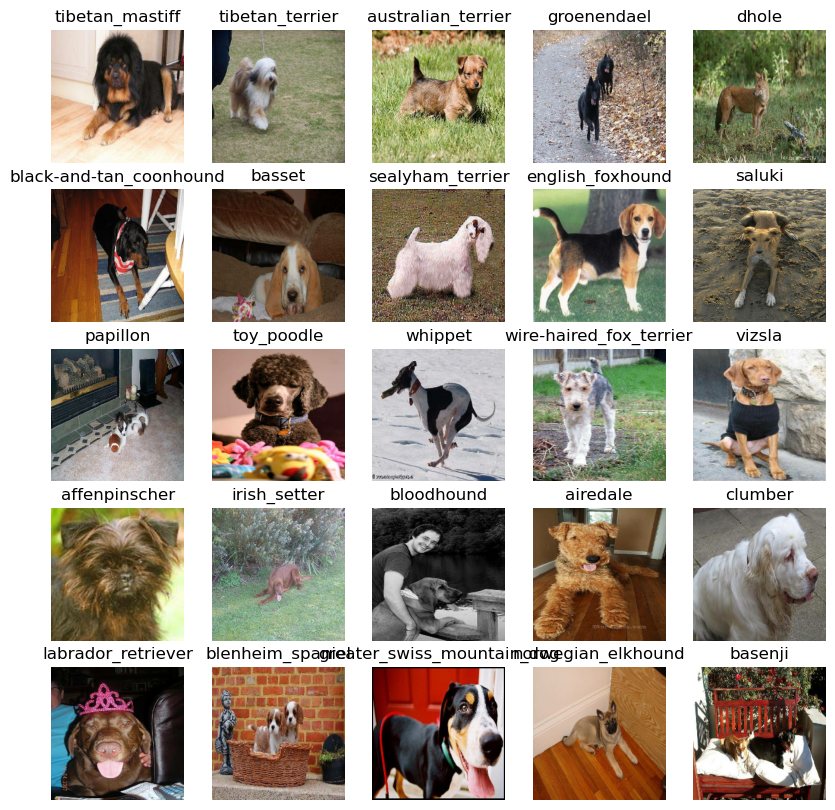

In [29]:
# Visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)


## Picking and building a model

Things to define before the model it built:
* The input shape (image shape, in the form of Tensors)
* The output shape (image labels, in the form of Tensors)
* The URL of the model to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [30]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  # Batch, height, width, color channels

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Create a function that:
* Takes an input shape, output shape and the model as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it will be getting)
* Returns the model

In [31]:
# Create a function that builds a Keras model
def create_model(
    input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL
):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential(
        [
            hub.KerasLayer(MODEL_URL),
            tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model


In [ ]:
model = create_model()
